# Ensemble Learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['red', 'blue'])

## Bagging ensemble experiment

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()

X = dataset.data
y = dataset.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

Baseline decision tree accuracy

In [3]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier().fit(X_train, y_train)
clf.score(X_test, y_test)

0.9210526315789473

Bagging decision tree class

In [37]:
from typing import Literal
from sklearn.tree import DecisionTreeClassifier

class BaggingDT:
    def __init__(self, n_bootstrap_size=32, n_learners=10, strategy: Literal['avg', 'median', 'min', 'max', 'prod'] = 'avg') -> None:
        self.n_bootstrap_size = n_bootstrap_size
        self.n_learners = n_learners
        self.learners = None
        self.strategy = strategy

    def fit(self, X: np.ndarray, y: np.ndarray):
        self.learners = []
        bootstrap_indices = [
            np.random.choice(X.shape[0], size=self.n_bootstrap_size, replace=True) 
            for _ in range(self.n_learners)
        ]

        for idx in bootstrap_indices:
            X_sample = X[idx, :]
            y_sample = y[idx]
            clf = DecisionTreeClassifier().fit(X_sample, y_sample)
            self.learners.append(clf)

        return self
    
    def predict_proba(self, X: np.ndarray):
        y_preds = np.array([l.predict(X) for l in self.learners])
        if self.strategy == 'avg':
            return np.sum(y_preds, axis=0) / self.n_learners
        elif self.strategy == 'median':
            return np.median(y_preds, axis=0)
        elif self.strategy == 'min':
            return np.min(y_preds, axis=0)
        elif self.strategy == 'max':
            return np.max(y_preds, axis=0)
        elif self.strategy == 'prod':
            return np.prod(y_preds, axis=0)

    def predict(self, X: np.ndarray):
        y_pred = (self.predict_proba(X) > 0.5)*1
        return y_pred

    def score(self, X: np.ndarray, y: np.ndarray):
        y_pred = self.predict(X)
        return np.sum(y_pred == y) / y.shape[0]

In [44]:
bdt = BaggingDT(n_bootstrap_size=X_train.shape[0], n_learners=200).fit(X_train, y_train)
bdt.score(X_test, y_test)

0.9824561403508771

In [46]:
strats = ['avg', 'median', 'min', 'max', 'prod']

for strat in strats:
    bdt = BaggingDT(n_bootstrap_size=X_train.shape[0], n_learners=200, strategy=strat).fit(X_train, y_train)
    acc = bdt.score(X_test, y_test)
    print(f"{strat} -- {acc}")

avg -- 0.9824561403508771
median -- 0.9824561403508771
min -- 0.6842105263157895
max -- 0.8157894736842105
prod -- 0.6754385964912281


### Hypothesis testing

$H_0: \mu_{bag} = \mu_{dt}$

$H_1: \mu_{bag} \neq \mu_{dt}$

In [10]:
n_reps = 100

acc_bagging = []
acc_baseline = []

for _ in range(n_reps):
    clf = DecisionTreeClassifier().fit(X_train, y_train)
    acc_baseline.append(clf.score(X_test, y_test))

    bdt = BaggingDT(n_bootstrap_size=X_train.shape[0], n_learners=200).fit(X_train, y_train)
    acc_bagging.append(bdt.score(X_test, y_test))
    
acc_bagging = np.array(acc_bagging)
acc_baseline = np.array(acc_baseline)

In [11]:
from scipy.stats import ttest_rel

ttest_rel(acc_bagging, acc_baseline)

TtestResult(statistic=2.654251667131275, pvalue=0.009262054070371409, df=99)

p-value is extremely small, thus we reject $H_0$, and can conclude that with (probably alot more than) 95% certainty, that the mean accuracies are not equal. 

<AxesSubplot: >

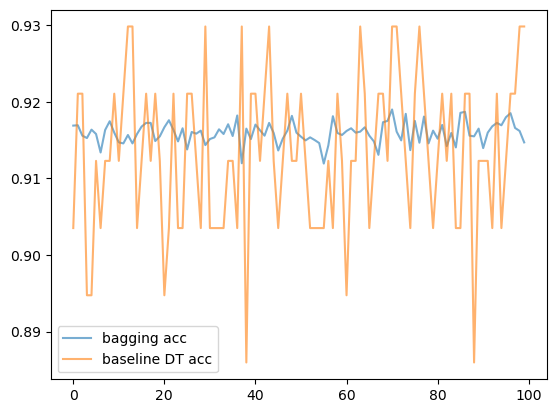

In [12]:
sns.lineplot(acc_bagging, alpha=0.6, label='bagging acc')
sns.lineplot(acc_baseline, alpha=0.6, label='baseline DT acc')

We see that the bagging approach has averaged the model variance quite a bit, while still maintaining the same amount of model bias.

## Boosting

### Naive boosting approach

In [ ]:
# create 3 roughly equal subsets  
sub_size = [X_train.shape[0]//3 * x for x in range(3)] + [None]
indices = [[x, y] for x, y in zip(np.roll(sub_size, 1), sub_size)][1:]

# partition dataset in 3
[X1, y1], [X2, y2], [X3, y3] = [[X_train[imin:imax], y_train[imin:imax]] for imin, imax in indices]

#### part 1: train d1 with X1
d1 = DecisionTreeClassifier().fit(X1, y1)

# take X2 and feed it to d1
y1_pred = d1.predict(X2)
# misclassified instances become new X2
X2_d1_mis = X2[y1_pred != y2]
y2_d1_mis = y2[y1_pred != y2]

#### part 2: train d2 with new X2 
d2 = DecisionTreeClassifier().fit(X2_d1_mis, y2_d1_mis)
 
# instances on which d1 and d2 disagree form training set for d3
y1_pred = d1.predict(X3)
y2_pred = d2.predict(X3)
X3_disagree_d12 = X3[y1_pred != y2_pred]
y3_disagree_d12 = y3[y1_pred != y2_pred]

#### part 3: train d3 with new X3
d3 = DecisionTreeClassifier().fit(X3_disagree_d12, y3_disagree_d12)

In [ ]:
### testing: use X_test to predict with d1 and d2
y1_pred = d1.predict(X_test)
y2_pred = d2.predict(X_test)

# which indices correspond to d1 and d2 agree/disagree'ing 
agree_indices = np.where(y1_pred == y2_pred)
disagree_indices = np.where(y1_pred != y2_pred)

# get disagreed X_test (the instances that both d1 and d2 could not decide on)
X_disagree = X_test[disagree_indices]
y3_pred = d3.predict(X_disagree)

# new array
y_pred = np.zeros((X_test.shape[0], ))
# fill array with (y1 == y2) agreed predictions and the predictions of y3 
y_pred[agree_indices] = y1_pred[agree_indices]
y_pred[disagree_indices] = y3_pred

In [ ]:
np.sum(y_pred == y_test) / y_pred.shape[0]

0.9385964912280702

### Boosting class

In [23]:
class BoostingDT:
    def __init__(self) -> None:
        self.d_clfs = []
    
    def fit(self, X: np.ndarray, y: np.ndarray):
        # create 3 roughly equal subsets  
        sub_size = [X.shape[0]//3 * x for x in range(3)] + [None]
        indices = [[i, j] for i, j in zip(np.roll(sub_size, 1), sub_size)][1:]

        # partition dataset in 3
        [X1, y1], [X2, y2], [X3, y3] = [[X[imin:imax], y[imin:imax]] for imin, imax in indices]

        #### part 1: train d1 with X1
        d1 = DecisionTreeClassifier().fit(X1, y1)

        # take X2 and feed it to d1
        y1_pred = d1.predict(X2)
        # misclassified instances become new X2
        X2_d1_mis = X2[y1_pred != y2]
        y2_d1_mis = y2[y1_pred != y2]

        #### part 2: train d2 with new X2 
        d2 = DecisionTreeClassifier().fit(X2_d1_mis, y2_d1_mis)
        
        # instances on which d1 and d2 disagree form training set for d3
        y1_pred = d1.predict(X3)
        y2_pred = d2.predict(X3)
        X3_disagree_d12 = X3[y1_pred != y2_pred]
        y3_disagree_d12 = y3[y1_pred != y2_pred]

        #### part 3: train d3 with new X3
        d3 = DecisionTreeClassifier().fit(X3_disagree_d12, y3_disagree_d12)

        self.d_clfs = [d1, d2, d3]
        return self
    
    def predict(self, X: np.ndarray):
        
        [d1, d2, d3] = self.d_clfs
        ### testing: use X_test to predict with d1 and d2
        y1_pred = d1.predict(X)
        y2_pred = d2.predict(X)

        # which indices correspond to d1 and d2 agree/disagree'ing 
        agree_indices = np.where(y1_pred == y2_pred)
        disagree_indices = np.where(y1_pred != y2_pred)

        # get disagreed X_test (the instances that both d1 and d2 could not decide on)
        X_disagree = X[disagree_indices]
        y3_pred = d3.predict(X_disagree)

        # new array
        y_pred = np.zeros((X.shape[0], ))
        # fill array with (y1 == y2) agreed predictions and the predictions of y3 
        y_pred[agree_indices] = y1_pred[agree_indices]
        y_pred[disagree_indices] = y3_pred
        return y_pred
    
    def score(self, X: np.ndarray, y: np.ndarray):
        y_pred = self.predict(X)
        return np.sum(y_pred == y) / y.shape[0]

In [24]:
boost_dt = BoostingDT().fit(X_train, y_train)

boost_dt.score(X_test, y_test)

0.9473684210526315

## AdaBoost

In [106]:
d_clfs = []
weights = []

ada_X = X_train
ada_y = y_train

p = np.zeros_like(ada_y, dtype='float64')
p.fill(1/ada_y.shape[0])

for _ in range(100):
    d = DecisionTreeClassifier(max_depth=1, splitter='random').fit(ada_X, ada_y)
    y_pred = d.predict(ada_X)
    e = np.sum(y_pred != ada_y) / ada_y.shape[0]
    if e > 0.5 or e == 0: break

    b = e / (1-e)
    print(b, e)
    d_clfs.append(d)
    weights.append(np.log(1/b))
    
    p = np.where(y_pred != ada_y, b*p, p)
    p = p/p.sum()

    idx = np.random.choice(ada_y.shape[0], size=ada_y.shape[0], replace=True, p=p)

    ada_X = X_train[idx]
    ada_y = y_train[idx]

weights = np.array(weights) / np.sum(weights)

0.0963855421686747 0.08791208791208792
0.08851674641148326 0.08131868131868132
0.09112709832134293 0.08351648351648351
0.12068965517241381 0.1076923076923077
0.05324074074074074 0.05054945054945055
0.338235294117647 0.25274725274725274
0.04357798165137614 0.041758241758241756
0.21010638297872342 0.17362637362637362
0.17268041237113405 0.14725274725274726
0.10705596107055962 0.0967032967032967
0.22311827956989247 0.1824175824175824
0.03174603174603175 0.03076923076923077
0.09112709832134293 0.08351648351648351
0.03409090909090909 0.03296703296703297
0.08333333333333333 0.07692307692307693
0.07058823529411765 0.06593406593406594
0.02708803611738149 0.026373626373626374
0.20689655172413796 0.17142857142857143
0.013363028953229397 0.013186813186813187
0.08851674641148326 0.08131868131868132
0.06557377049180328 0.06153846153846154
0.03174603174603175 0.03076923076923077
0.35014836795252224 0.25934065934065936
0.0963855421686747 0.08791208791208792
0.06557377049180328 0.06153846153846154
0.1

In [107]:
y_pred = np.array([d.predict(X_test) * w for d, w in zip(d_clfs, weights)])
# y_pred = (y_pred.sum(axis=0) > 0.5)*1
y_pred = y_pred.sum(axis=0)

acc = np.sum((y_pred>0.5)*1 == y_test)/y_test.shape[0]
mse = np.sum((y_pred - y_test)**2) / y_test.shape[0]

acc, mse

(0.9122807017543859, 0.06497694755224633)

### AdaBoost class

In [130]:
class AdaBoostDT:
    def __init__(self, max_iter=100) -> None:
        self.max_iter = max_iter
        self.d_clfs = None
        self.weights = None
    
    def fit(self, X: np.ndarray, y: np.ndarray):
        self.d_clfs = []
        self.weights = []

        ada_X = X
        ada_y = y

        p = np.zeros_like(ada_y, dtype='float64')
        p.fill(1/ada_y.shape[0])

        for _ in range(self.max_iter):
            d = DecisionTreeClassifier(max_depth=2).fit(ada_X, ada_y)
            y_pred = d.predict(ada_X)
            e = np.sum(y_pred != ada_y) / ada_y.shape[0]
            if e > 0.5 or np.isclose(e, 0): break

            b = e / (1-e)
            self.d_clfs.append(d)
            self.weights.append(np.log(1/b))

            p = np.where(y_pred != ada_y, b*p, p)
            p = p/p.sum()

            idx = np.random.choice(ada_y.shape[0], size=ada_y.shape[0], replace=True, p=p)

            ada_X = X[idx]
            ada_y = y[idx]

        self.weights = np.array(self.weights) / np.sum(self.weights)
        return self
    
    def predict(self, X: np.ndarray):
        y_pred = np.array([d.predict(X) * w for d, w in zip(self.d_clfs, self.weights)])
        y_pred = (y_pred.sum(axis=0) > 0.5)*1
        return y_pred
        
    def predict_proba(self, X: np.ndarray):
        y_pred = np.array([d.predict(X) * w for d, w in zip(self.d_clfs, self.weights)])
        y_pred = y_pred.sum(axis=0)
        return y_pred
        
    def score(self, X: np.ndarray, y: np.ndarray):
        y_pred = self.predict(X)
        return np.sum(y_pred == y)/y.shape[0]

In [160]:
ada = AdaBoostDT().fit(X_train, y_train)
ada.score(X_test, y_test)

0.9122807017543859

<AxesSubplot: >

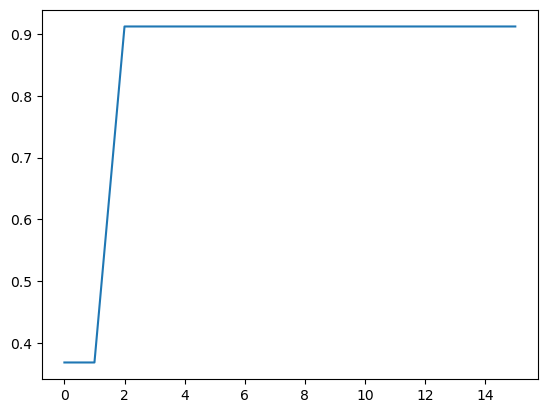

In [161]:
acc_ada = []
N = 16
ada = AdaBoostDT(max_iter=N).fit(X_train, y_train)

for i in range(N):
    y_pred = np.array([d.predict(X_test) * w for d, w in zip(ada.d_clfs[:i], ada.weights[:i])])
    y_pred = (y_pred.sum(axis=0) > 0.5)*1
    acc_ada.append(np.sum(y_pred == y_test)/y_test.shape[0])

sns.lineplot(acc_ada)

In [162]:
acc_ada

[0.3684210526315789,
 0.3684210526315789,
 0.9122807017543859,
 0.9122807017543859,
 0.9122807017543859,
 0.9122807017543859,
 0.9122807017543859,
 0.9122807017543859,
 0.9122807017543859,
 0.9122807017543859,
 0.9122807017543859,
 0.9122807017543859,
 0.9122807017543859,
 0.9122807017543859,
 0.9122807017543859,
 0.9122807017543859]

## Sklearn ensembles

In [449]:
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

est = DecisionTreeClassifier()

models = [
    BaggingClassifier(est), 
    AdaBoostClassifier(est), 
    GradientBoostingClassifier(), 
    RandomForestClassifier(), 
    StackingClassifier([('dt', est), ('svm', SVC())])
]

for model in models:
    clf = model.fit(X_train, y_train)
    print(model, clf.score(X_test, y_test))


BaggingClassifier(base_estimator=DecisionTreeClassifier()) 0.9649122807017544
AdaBoostClassifier(base_estimator=DecisionTreeClassifier()) 0.9385964912280702
GradientBoostingClassifier() 0.9736842105263158
RandomForestClassifier() 0.9824561403508771
StackingClassifier(estimators=[('dt', DecisionTreeClassifier()),
                               ('svm', SVC())]) 0.956140350877193


In [69]:
N = 5
d = 3
k = 2

X = np.random.randn(N, d)
W = np.random.randn(d, k)

In [71]:
X @ W

array([[-2.90783886, -0.16293061],
       [ 1.14661322,  2.82475912],
       [-0.15074701,  0.98223565],
       [-4.18984657,  0.45515582],
       [-0.3242991 , -1.46699468]])

In [81]:
X - X.mean(axis=0)

array([[-0.09879145, -0.50865815,  0.21541023],
       [-0.25959562,  1.72897488,  0.36816165],
       [-0.81019826, -0.46547401, -1.00876163],
       [ 0.05240213,  0.52285902,  1.59475403],
       [ 1.1161832 , -1.27770174, -1.16956428]])

In [73]:
x = X[0, :].reshape(-1, 1)

W.T @ x

array([[-2.90783886],
       [-0.16293061]])

In [75]:
W.T @ X.T

array([[-2.90783886,  1.14661322, -0.15074701, -4.18984657, -0.3242991 ],
       [-0.16293061,  2.82475912,  0.98223565,  0.45515582, -1.46699468]])